# 1. Projekat iz predmeta Mašinsko učenje

Eye State Classification - EEG
https://www.kaggle.com/datasets/robikscube/eye-state-classification-eeg-dataset/data

Marija Cvetković 1940

Luka Kocić 2022

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif


In [28]:
df = pd.read_csv("input-eeg.csv")

## 1. Analiza podataka

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14980 entries, 0 to 14979
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AF3           14980 non-null  float64
 1   F7            14980 non-null  float64
 2   F3            14980 non-null  float64
 3   FC5           14980 non-null  float64
 4   T7            14980 non-null  float64
 5   P7            14980 non-null  float64
 6   O1            14980 non-null  float64
 7   O2            14980 non-null  float64
 8   P8            14980 non-null  float64
 9   T8            14980 non-null  float64
 10  FC6           14980 non-null  float64
 11  F4            14980 non-null  float64
 12  F8            14980 non-null  float64
 13  AF4           14980 non-null  float64
 14  eyeDetection  14980 non-null  int64  
dtypes: float64(14), int64(1)
memory usage: 1.7 MB


In [30]:
df.describe()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeDetection
count,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000
mean,4321.917777,4009.767694,4264.022433,4164.946326,4341.741075,4644.022379,4110.400160,4616.056904,4218.826610,4231.316200,4202.456900,4279.232774,4615.205336,4416.435832,0.448798
std,2492.072174,45.941672,44.428052,5216.404632,34.738821,2924.789537,4600.926543,29.292603,2136.408523,38.050903,37.785981,41.544312,1208.369958,5891.285043,0.497388
min,1030.770000,2830.770000,1040.000000,2453.330000,2089.740000,2768.210000,2086.150000,4567.180000,1357.950000,1816.410000,3273.330000,2257.950000,86.666700,1366.150000,0.000000
25%,4280.510000,3990.770000,4250.260000,4108.210000,4331.790000,4611.790000,4057.950000,4604.620000,4190.770000,4220.510000,4190.260000,4267.690000,4590.770000,4342.050000,0.000000
50%,4294.360000,4005.640000,4262.560000,4120.510000,4338.970000,4617.950000,4070.260000,4613.330000,4199.490000,4229.230000,4200.510000,4276.920000,4603.080000,4354.870000,0.000000
75%,4311.790000,4023.080000,4270.770000,4132.310000,4347.180000,4626.670000,4083.590000,4624.100000,4209.230000,4239.490000,4211.280000,4287.180000,4617.440000,4372.820000,1.000000
max,309231.000000,7804.620000,6880.510000,642564.000000,6474.360000,362564.000000,567179.000000,7264.100000,265641.000000,6674.360000,6823.080000,7002.560000,152308.000000,715897.000000,1.000000


In [31]:
df['eyeDetection'].value_counts()

eyeDetection
0    8257
1    6723
Name: count, dtype: int64

Da bismo razumeli kako da izaberemo koje informacije želimo da uključimo u treniranje našeg model treba da znamo osnovne stvari o kolona koje imamo.
Opisi kolona:
Svaki od ovih parametara je električni signal sa određene pozicije na glavi meren u vremenu.

1. AF3 i AF4 se nalaze kod obrva i izuzetno su osetljivi na pokrete očiju. Kada se oko zatvori ili trepne trebalo bi da signal pravi veliki pik
2. F7 i F8 blizu očiju, levo i desno.
3. F3 i F4 takođe blizu očiju, ali ne koliko i prethodna dva
4. FC5 i FC6 mešavina frontalne i centralne aktivnosti
5. T7 i T8 nalaze se sa strane glave i ne bi trebalo toliko da utiču na treptaje, nalaze se daleko
6. P7 i P8 su senzorni regioni
7. O1 i O2 direktno vezani za vid, tako da bi trebalo da jako utiču.

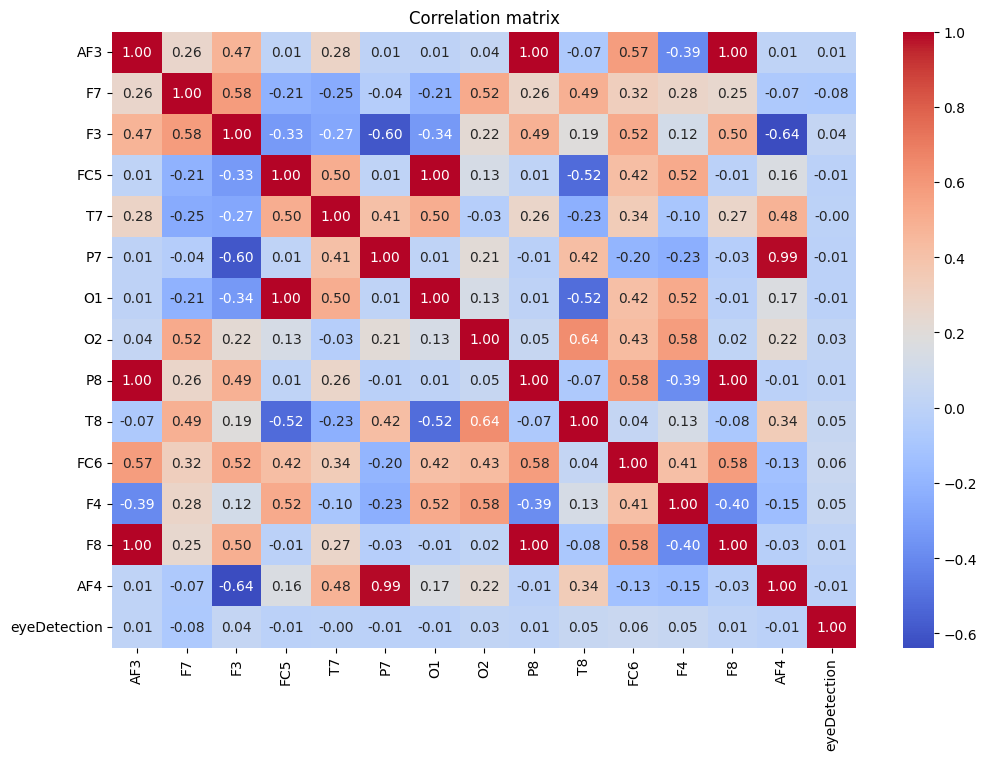

In [32]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True, fmt='.2f')
plt.title("Correlation matrix")
plt.show()

Na osnovu matrice korelacije možemo da zaključimo sledeće:
1. EyeDetection kolona prema matrici korelacije trenutno nema linearnu vezu sa ostalim kanalima sve vrednosti su izmedju 0.00 i -0.06 (jer je eyeDetection boolean)

2. Postoje visoke korelacije izmedju AF3 i F8 (1.00), AF3 i P8 (1.00), P8 i F8(1.00), FC5 i O1 (1.00), PC8 i F8 (1.00)  kao i izmedju P7 i AF4(0.99). Imamo duplirane podatke što znači da model može da bude nestabilan. Možemo da izbacimo jednu kolonu iz svakog od navedenih parova.

Za izbor kolone za isključivanje biće korišćena point-beserial korelacija sa eyeDetection kolonom:

In [33]:
from scipy.stats import pointbiserialr

for col in df.select_dtypes(include='number'):
    corr, p_value = pointbiserialr(df["eyeDetection"], df[col])
    print(f"{col}: {abs(corr):.4f}")

AF3: 0.0105
F7: 0.0800
F3: 0.0389
FC5: 0.0075
T7: 0.0004
P7: 0.0078
O1: 0.0072
O2: 0.0251
P8: 0.0096
T8: 0.0472
FC6: 0.0643
F4: 0.0480
F8: 0.0131
AF4: 0.0075
eyeDetection: 1.0000


## 2. Deskriptivna analiza i čišćenje podataka

In [34]:
df.isnull().sum()

AF3             0
F7              0
F3              0
FC5             0
T7              0
P7              0
O1              0
O2              0
P8              0
T8              0
FC6             0
F4              0
F8              0
AF4             0
eyeDetection    0
dtype: int64

In [35]:
df.duplicated().any()

np.False_

In [36]:
df = df.drop_duplicates()

### Detekcija outlier-a


Box plot nad svim numerickim podacima

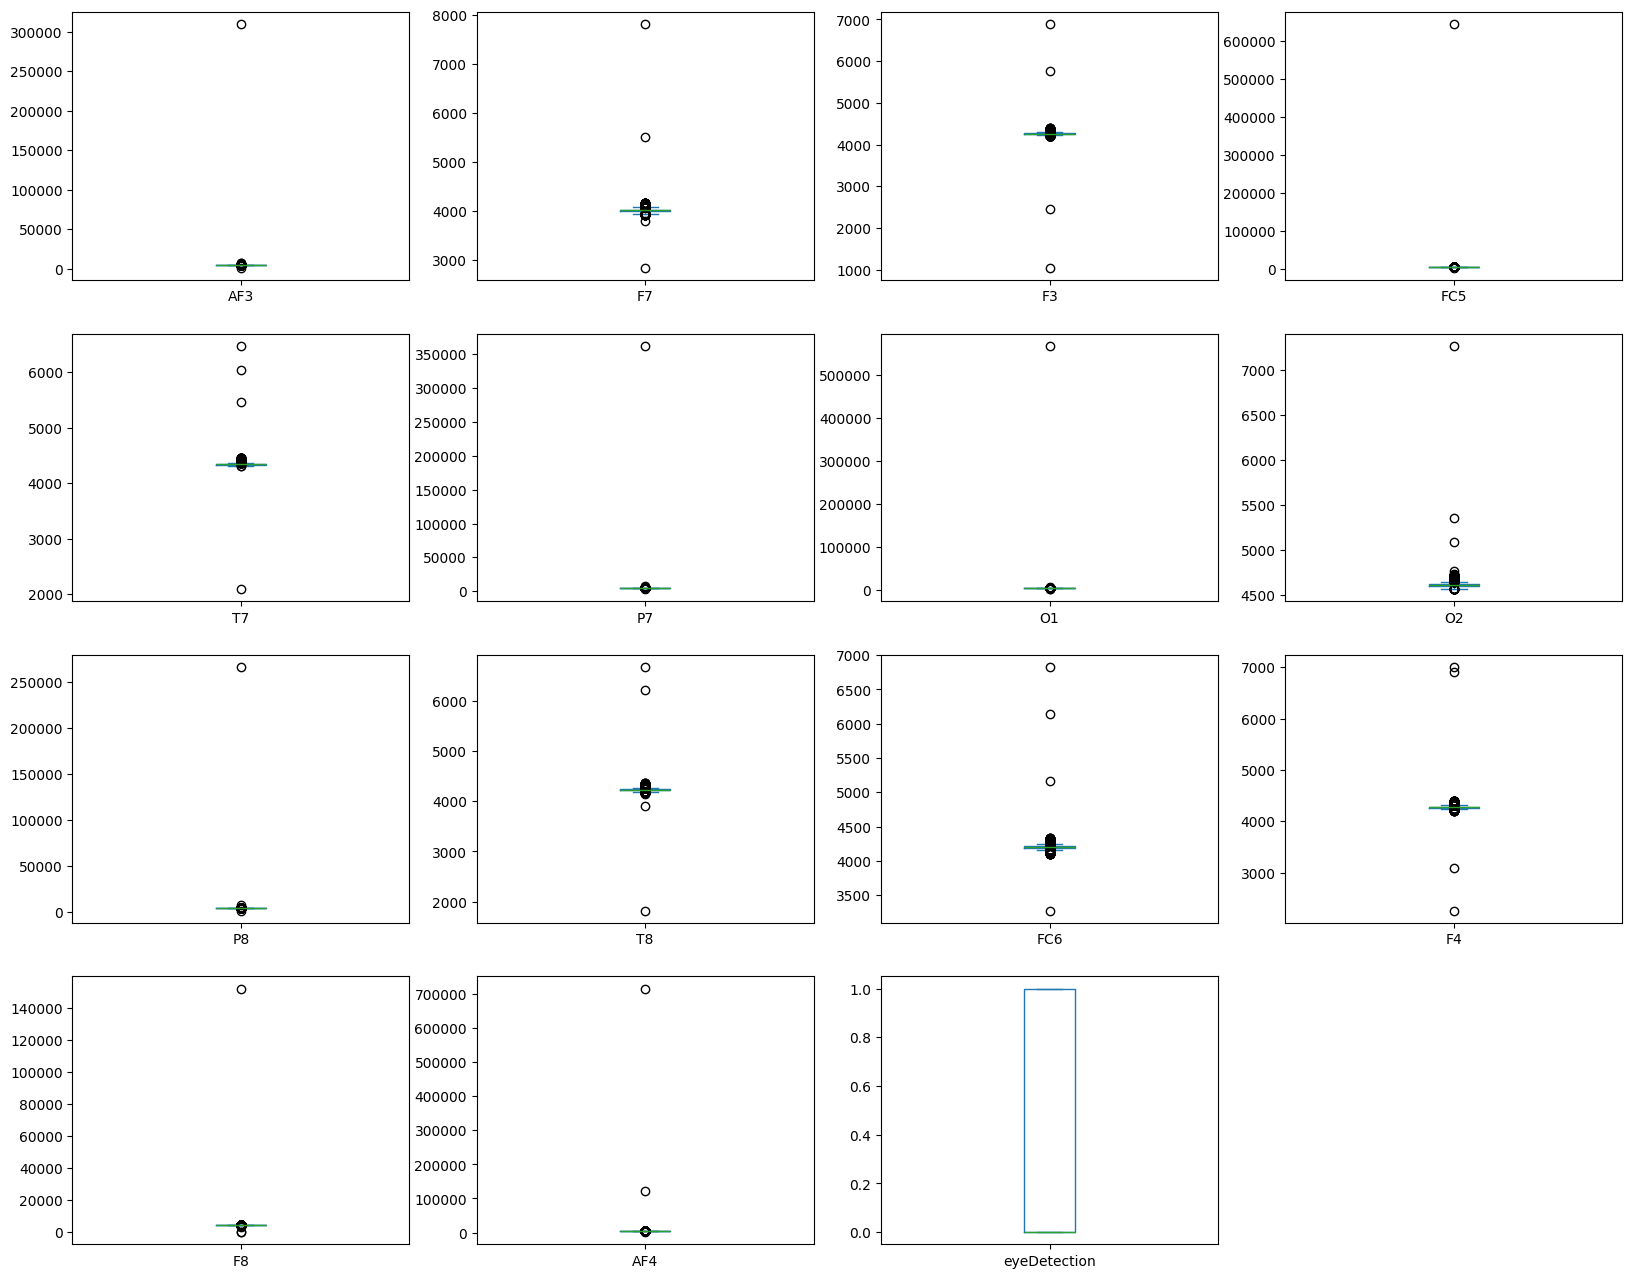

In [37]:
number_columns = df.select_dtypes(include='number')
number_columns.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False, figsize=(20,16))
plt.show()

Vizualizacija outlier-a pomoću boxplot-a, scatter plot-a i histograma:

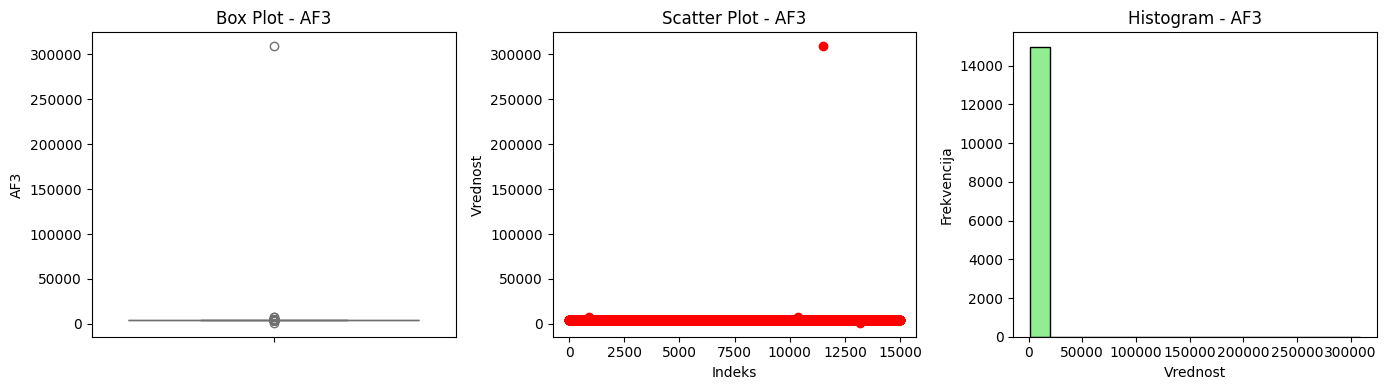

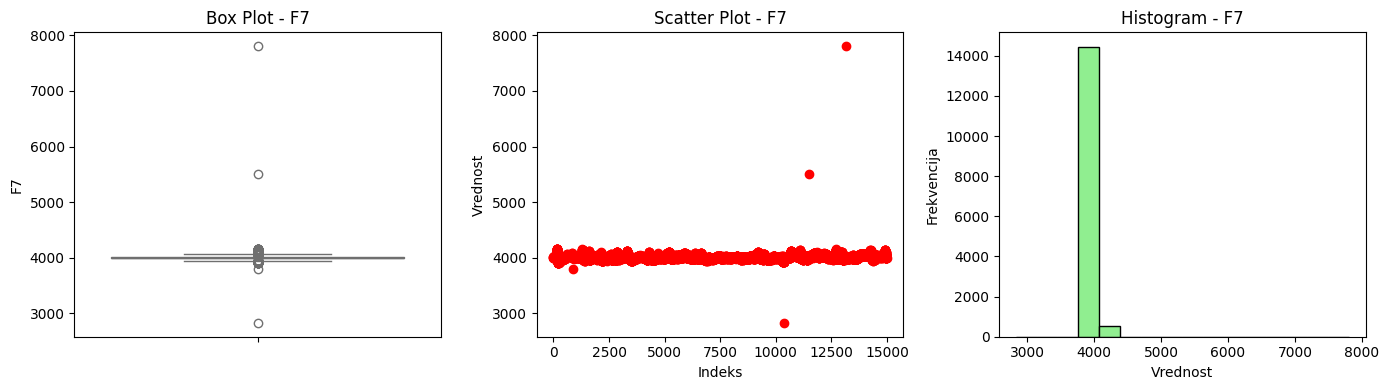

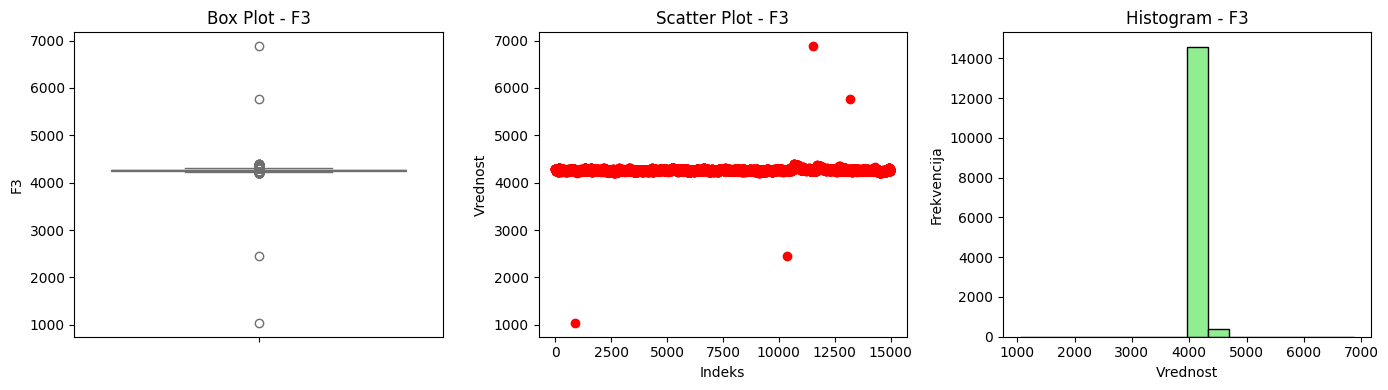

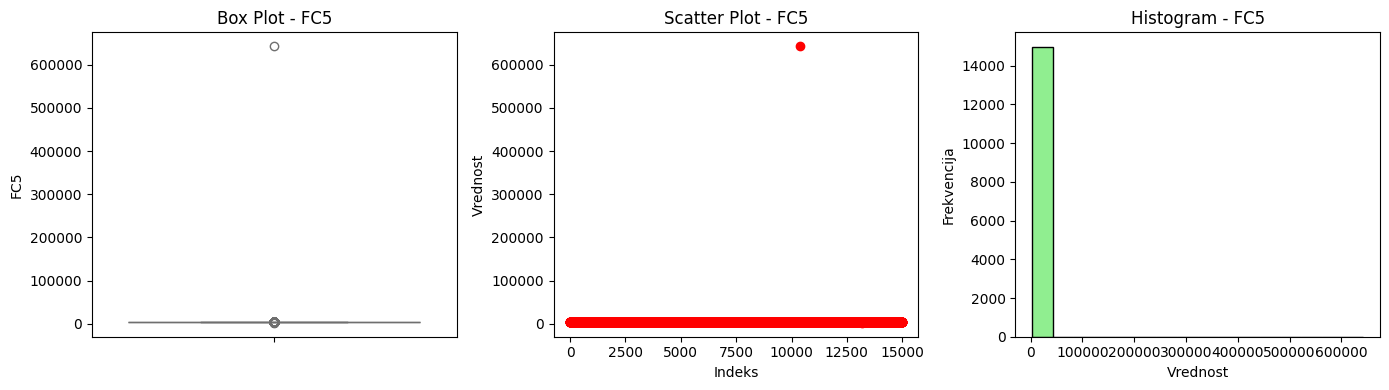

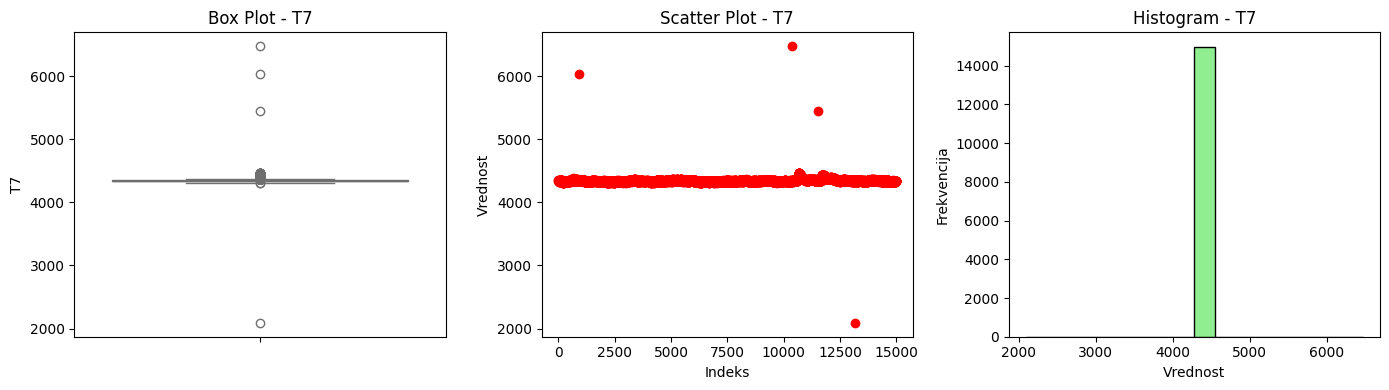

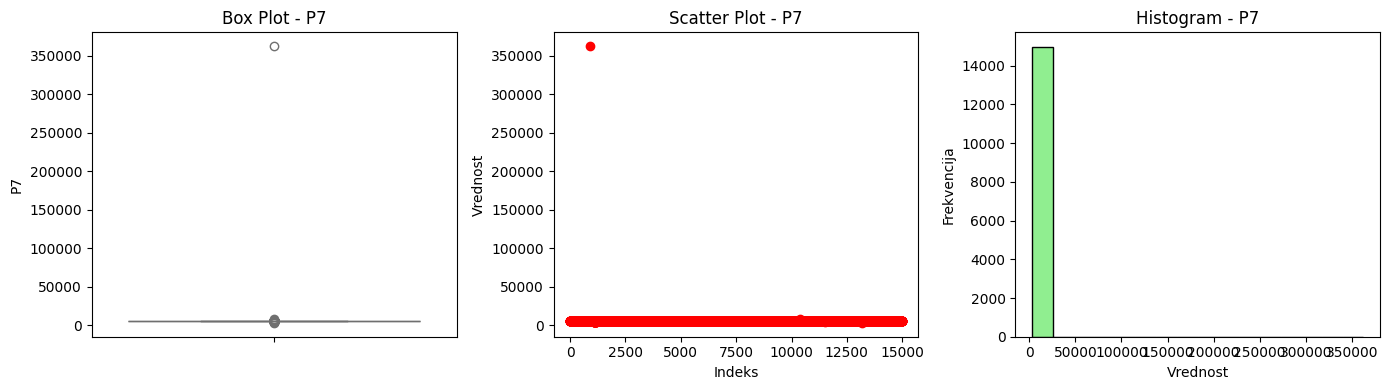

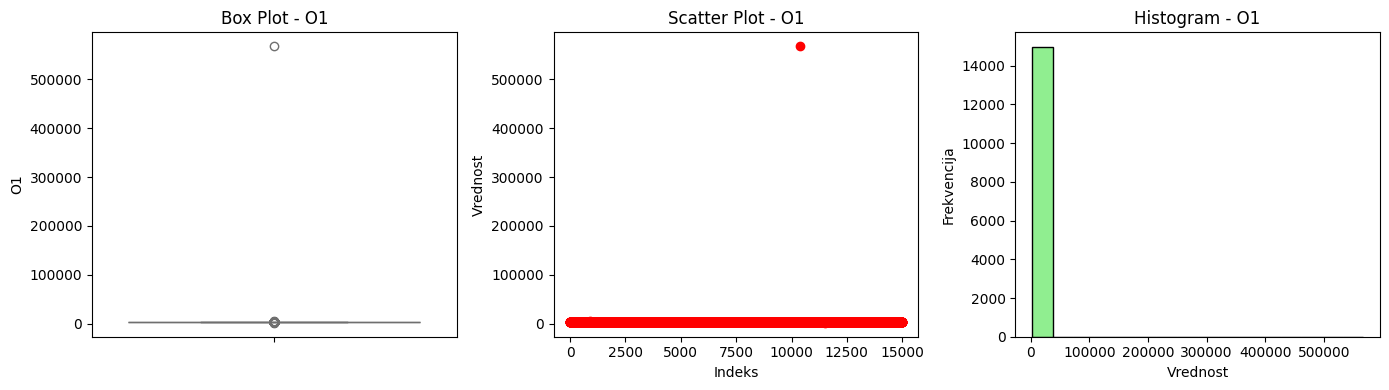

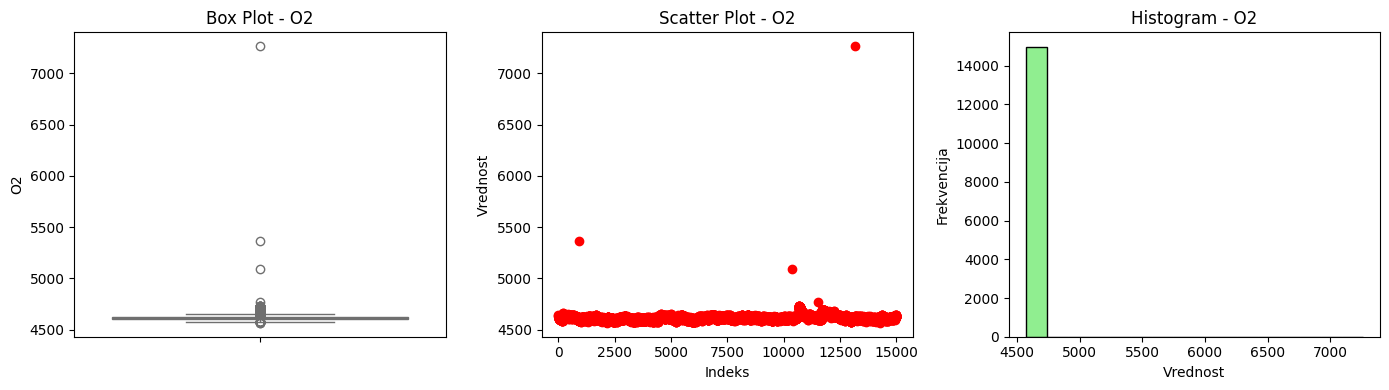

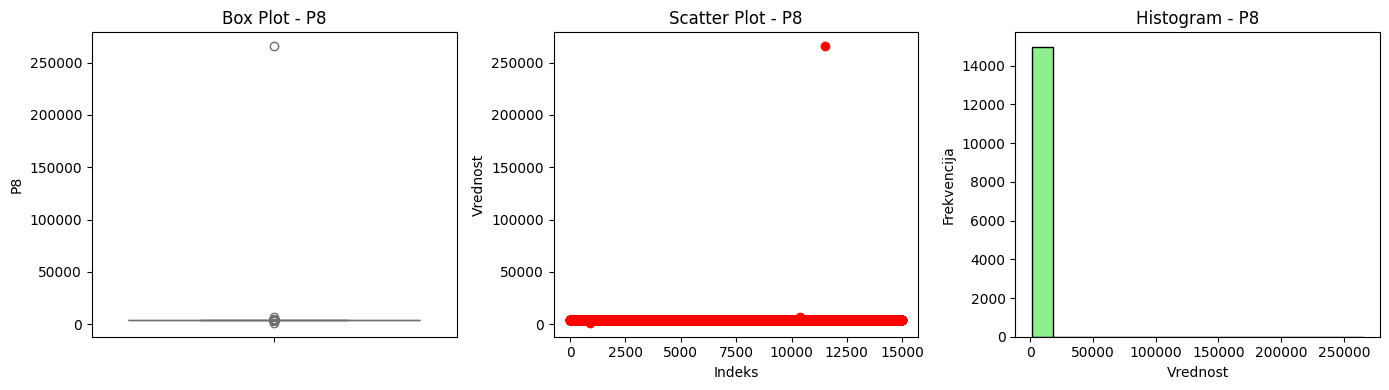

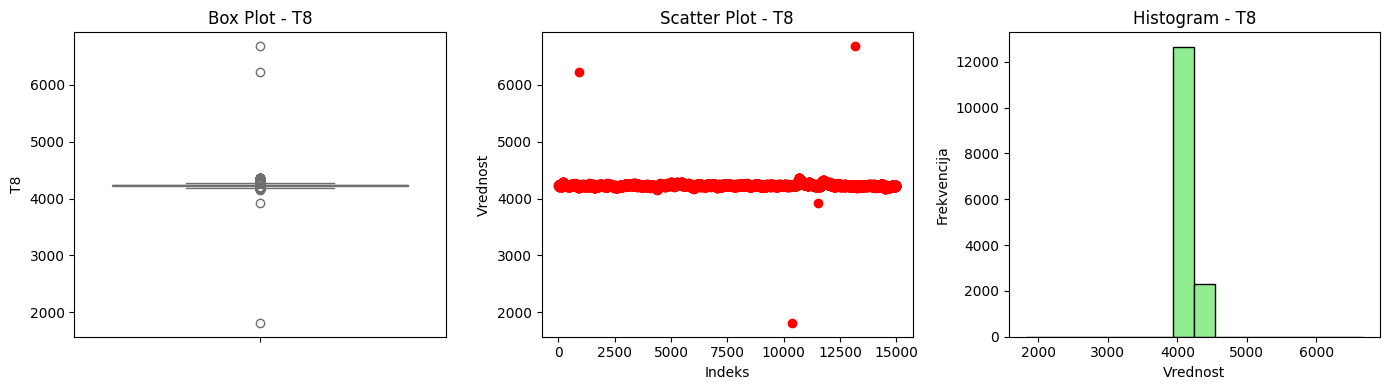

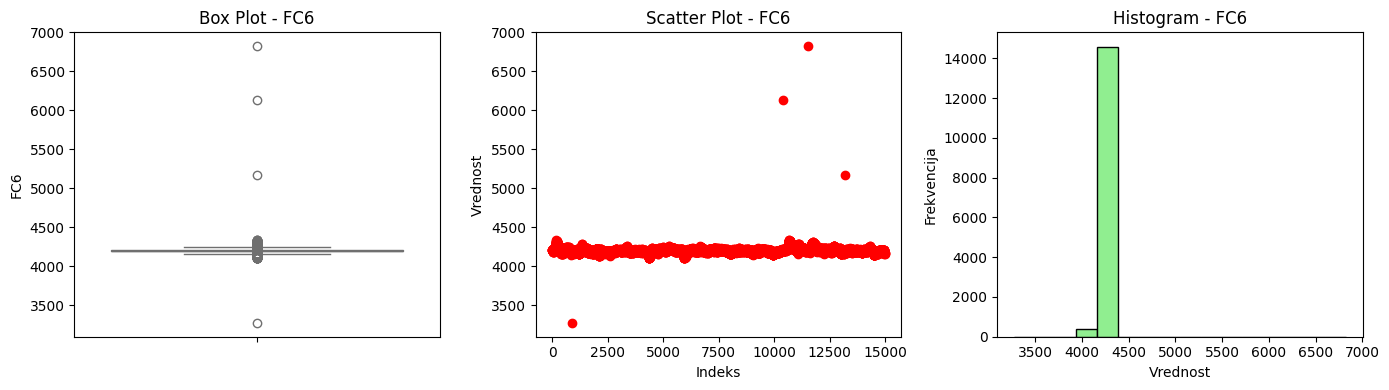

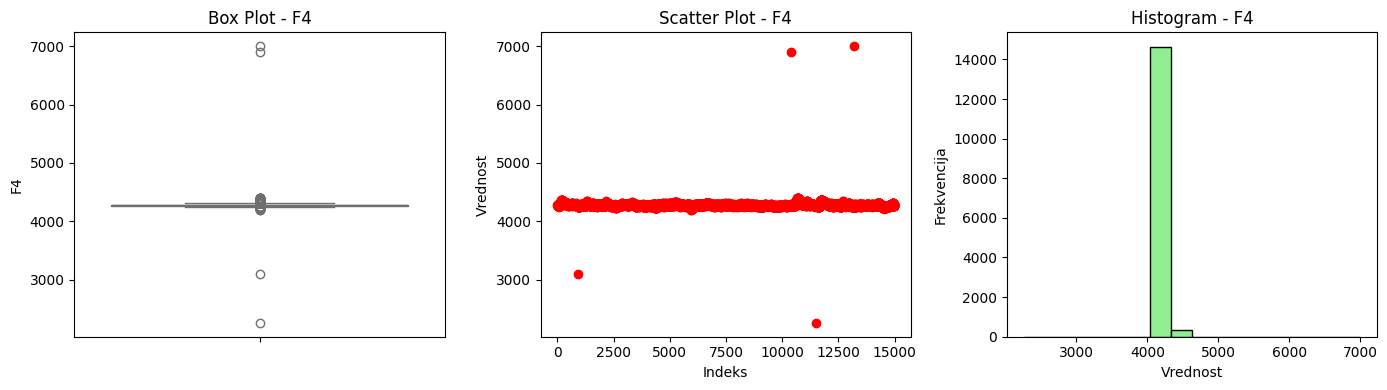

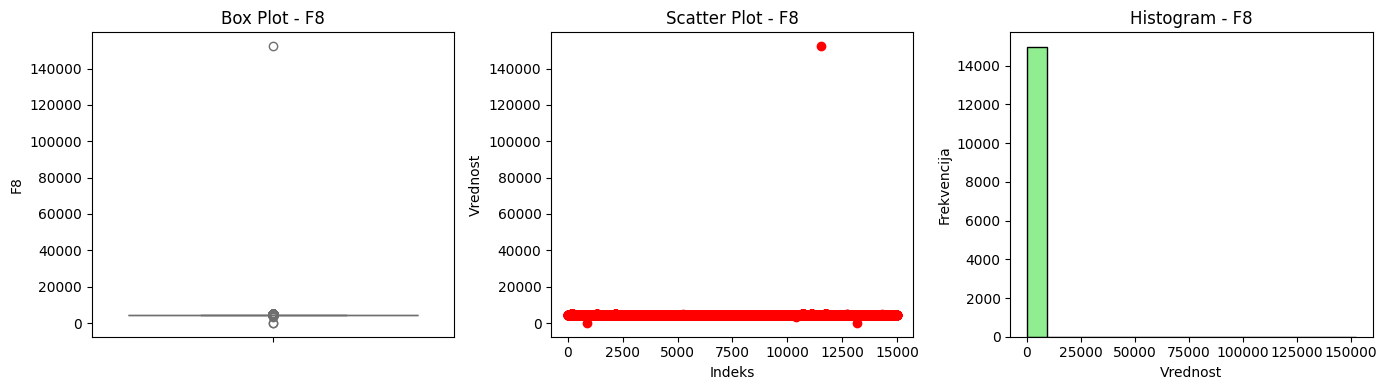

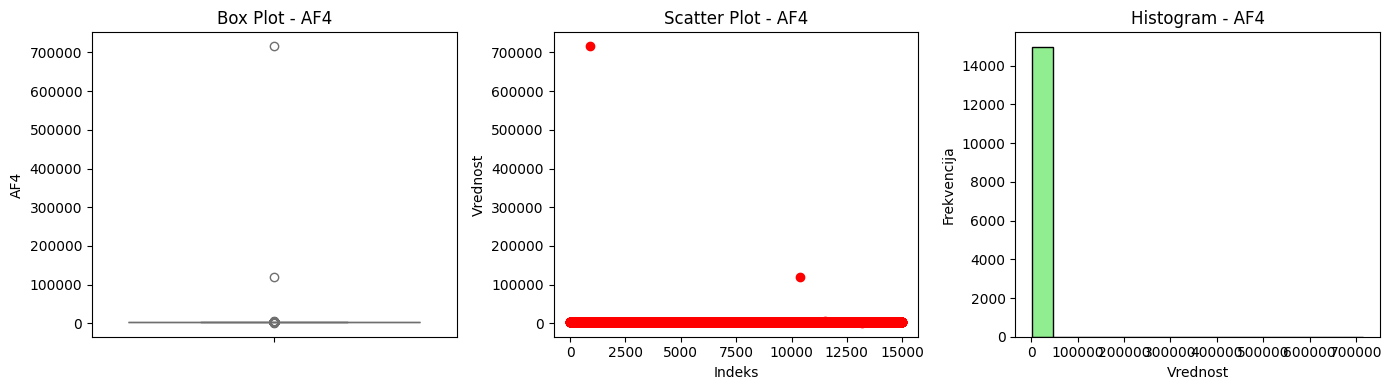

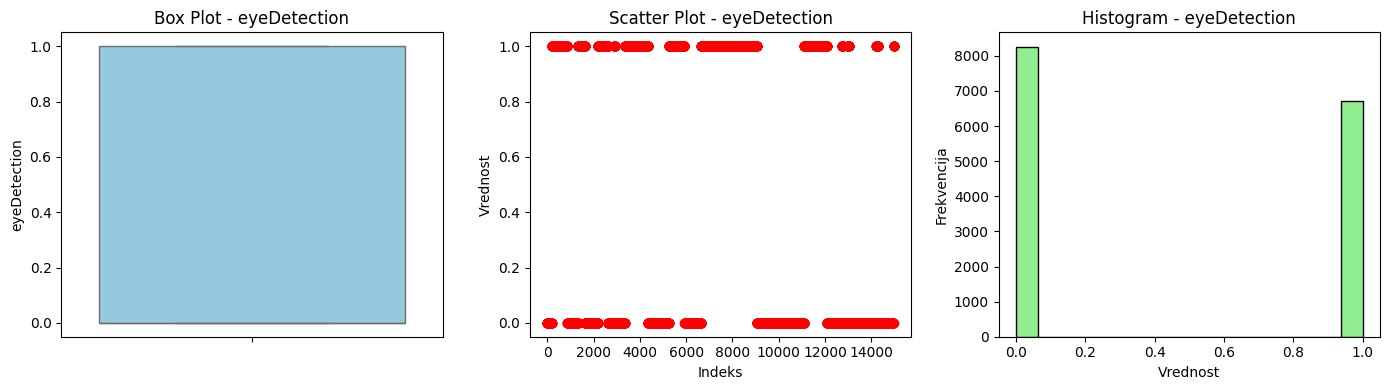

In [39]:
for column in number_columns.columns:
        plt.figure(figsize=(14, 4))
        
        # Box plot
        plt.subplot(1, 3, 1)
        sns.boxplot(y=df[column], color='skyblue')
        plt.title(f"Box Plot - {column}")
        
        # Scatter plot
        plt.subplot(1, 3, 2)
        plt.scatter(x=range(len(df)), y=df[column], color='red')
        plt.title(f"Scatter Plot - {column}")
        plt.xlabel("Indeks")
        plt.ylabel("Vrednost")
        
        # Histogram
        plt.subplot(1, 3, 3)
        plt.hist(df[column], bins=16, color='lightgreen', edgecolor='black')
        plt.title(f"Histogram - {column}")
        plt.xlabel("Vrednost")
        plt.ylabel("Frekvencija")
        
        plt.tight_layout()
        plt.show()

Primena IQR i Z_Score metode za detekciju outlier-a:

In [40]:
for column in number_columns.columns:
        print(f"\n--- Kolona: {column} ---")

        # IQR metoda
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        donja_granica = Q1 - 1.5 * IQR
        gornja_granica = Q3 + 1.5 * IQR
        outlieri_iqr = df[(df[column] < donja_granica) | (df[column] > gornja_granica)]
        print("Outlieri po IQR metodi:")
        print(outlieri_iqr)

        # Z-Score metoda
        mean = df[column].mean()
        std = df[column].std()
        z_scores = (df[column] - mean) / std
        outlieri_zscore = df[(z_scores > 3) | (z_scores < -3)]
        print("Outlieri po Z-Score metodi:")
        print(outlieri_zscore)


--- Kolona: AF3 ---
Outlieri po IQR metodi:
           AF3       F7       F3      FC5       T7       P7       O1       O2  \
152    4375.38  4072.82  4263.08  4150.26  4337.95  4582.56  4056.92  4599.49   
153    4401.54  4090.26  4267.18  4156.41  4336.92  4586.15  4053.33  4598.97   
154    4412.31  4094.36  4262.56  4149.23  4332.31  4591.79  4057.44  4611.28   
155    4416.92  4106.67  4261.03  4153.33  4334.87  4589.23  4062.56  4604.62   
156    4430.26  4123.08  4268.21  4156.92  4336.92  4592.31  4069.74  4592.82   
...        ...      ...      ...      ...      ...      ...      ...      ...   
14935  4397.95  4096.41  4296.92  4155.90  4331.79  4605.13  4063.08  4616.92   
14936  4389.74  4092.82  4287.69  4157.95  4335.38  4607.69  4062.05  4612.82   
14937  4385.13  4089.23  4279.49  4155.90  4334.36  4607.18  4056.92  4614.36   
14938  4374.36  4083.08  4280.00  4155.38  4331.28  4603.08  4053.85  4605.64   
14939  4362.05  4070.26  4280.51  4150.77  4332.31  4599.49  405

U primeru iznad smo detektovali da imamo outlier-e. Sledeći korak je da vidimo koja je najbolja metoda za njihovo otklanjanje. Prvo ćemo da vidimo koliko reodva ima najmanje jedan outliere, ako nije preveliki broj redova možemo ih samo izbrisati.

In [41]:
iqr_mask = pd.Series(False, index=df.index)
zscore_mask = pd.Series(False, index=df.index)

for column in number_columns.columns:
    # IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    donja = Q1 - 1.5 * IQR
    gornja = Q3 + 1.5 * IQR

    iqr_mask |= (df[column] < donja) | (df[column] > gornja)

    # Z-score
    std = df[column].std()
    if std != 0:
        z = (df[column] - df[column].mean()) / std
        zscore_mask |= (z > 3) | (z < -3)

print(f"Broj redova sa bar jednim IQR outlierom: {iqr_mask.sum()}")
print(f"Broj redova sa bar jednim Z-score outlierom: {zscore_mask.sum()}")


Broj redova sa bar jednim IQR outlierom: 3127
Broj redova sa bar jednim Z-score outlierom: 88


Veliki broj redova sadrži bar jedan outlier-e tako da odbacujemo opciju brisanja redova.

## 4. Treniranje modela

### Podela podataka:

In [ ]:
le = LabelEncoder()
y = df['eyeDetection']

X = df.drop(
    ['eyeDetection'],
    axis=1
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

### Lazy Predict

In [17]:
# from lazypredict.Supervised import LazyClassifier

# clf = LazyClassifier(
#     verbose=0, 
#     ignore_warnings=True, 
#     custom_metric=None, 
#     predictions=False,
# )

# models, predictions = clf.fit(X_train, X_test, y_train, y_test)

# print(models)

Funkcija za izveštaj o performansama modela:

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import numpy as np


def report(title=None, estimator=None, X=None, y=None, cv=5):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    y_true_all = []
    y_pred_all = []

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

        estimator.fit(X_train, y_train)
        y_pred_fold = estimator.predict(X_test)

        y_true_all.extend(list(y_test_fold))
        y_pred_all.extend(list(y_pred_fold))
        
    accuracy = accuracy_score(y_true_all, y_pred_all)

    return {
        "title": title,
        "accuracy": float(accuracy),
        "classification_report": classification_report(y_true_all, y_pred_all, output_dict=True),
        "confusion_matrix": confusion_matrix(y_true_all, y_pred_all)
    }

### Random Forest

In [45]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from imblearn.pipeline import Pipeline

def run_random_forest_classifier(preprocessors=None, X=None, y=None, cv=None, sampler=None):
    forest = RandomForestClassifier(random_state=42, n_jobs=1)
    
    steps = []
    if preprocessors:
        steps.extend([(f"prep_{i}", p) for i, p in enumerate(preprocessors)])
    if sampler is not None:
        steps.append(("sampler", sampler))
    steps.append(("model", forest))

    pipe = Pipeline(steps)
        
    res = report(estimator=pipe, X=X, y=y, title="Random Forest CV", cv=cv)
    return res["accuracy"]

### Extra Trees Classifier

Radi slično kao Random Forest Classifier, ali u praksi ima veću preciznost. \
n_estimators - broj stabala

In [46]:
from sklearn.ensemble import ExtraTreesClassifier


def run_extra_trees_classifier(preprocessors=None, X=None, y=None, cv=None, sampler=None):
    et_classifier = ExtraTreesClassifier(n_estimators=100, criterion='gini', random_state=42)

    steps = []
    if preprocessors:
        steps.extend([(f"prep_{i}", p) for i, p in enumerate(preprocessors)])
    if sampler is not None:
        steps.append(("sampler", sampler))
    steps.append(("model", et_classifier))

    pipe = Pipeline(steps)
    res = report(estimator=pipe, X=X, y=y, title="Extra Trees Classifier CV", cv=cv)
        
    return res["accuracy"]        

### K-Nearest Neighbours (KNN)

Lazy predictor \
K - broj najbiližih tačaka koje su uzimaju u obzir

In [47]:
from sklearn.neighbors import KNeighborsClassifier

def run_knn_classifier(preprocessors=None, X=None, y=None, cv=None, sampler=None):
    steps = []
    if preprocessors:
        steps.extend([(f"prep_{i}", p) for i, p in enumerate(preprocessors)])
    if sampler is not None:
        steps.append(("sampler", sampler))
    steps.append(("model", KNeighborsClassifier()))

    pipe = Pipeline(steps)  

    res = report(estimator=pipe, X=X, y=y, title="K-Nearest Neighbour Classifier CV", cv=cv)
    return res["accuracy"]

### SVM

In [48]:
from os import pipe
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

def run_svm_classifier(preprocessors=None, X=None, y=None, cv=None, sampler=None):
    steps = []
    if preprocessors:
        steps.extend([(f"prep_{i}", p) for i, p in enumerate(preprocessors)])
    if sampler is not None:
        steps.append(("sampler", sampler))
    steps.append(("model", SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)))

    pipe = Pipeline(steps)

    res = report(estimator=pipe, X=X, y=y, title="SVM Classifier CV", cv=cv)  
    return res["accuracy"]

### Logisticka regresija



Pogodna je za binarnu klasifikaciju.

In [49]:
from sklearn.linear_model import LogisticRegression
from xgboost import cv

def run_logistic_regression_classifier(preprocessors=None, X=None, y=None, cv=None, sampler=None):
    clf = LogisticRegression(
        n_jobs = 1, max_iter=1000, random_state=42
    )

    steps = []
    if preprocessors:
        steps.extend([(f"prep_{i}", p) for i, p in enumerate(preprocessors)])
    if sampler is not None:
        steps.append(("sampler", sampler))
    steps.append(("model", clf))

    pipe = Pipeline(steps)
    res = report(estimator=pipe, X=X, y=y, title="Logistic Regression Classifier CV", cv=cv)
    return res["accuracy"]

### Naive Bayes

Naivna metoda - algoritam smatra da je svaki fature nekorelisan.

In [50]:
from sklearn.naive_bayes import GaussianNB

def run_naive_bayes_classifier(preprocessors=None, X=None, y=None, cv=None, sampler=None):
    steps = []
    if preprocessors:
        steps.extend([(f"prep_{i}", p) for i, p in enumerate(preprocessors)])
    if sampler is not None:
        steps.append(("sampler", sampler))
    steps.append(("model", GaussianNB()))

    pipe = Pipeline(steps)

    res = report(estimator=pipe, X=X, y=y, title="Naive Bayes Classifier CV", cv=cv)
    return res["accuracy"]

### Decision Tree Classifier

Kreiranje stabla odlučivanja na osnovu feature-a

In [51]:
from sklearn.tree import DecisionTreeClassifier

def run_decision_tree_classifier(preprocessors=None, X=None, y=None, cv=None, sampler=None):
    clf = DecisionTreeClassifier(random_state=42)

    steps = []
    if preprocessors:
        steps.extend([(f"prep_{i}", p) for i, p in enumerate(preprocessors)])
    if sampler is not None:
        steps.append(("sampler", sampler))
    steps.append(("model", clf))

    pipe = Pipeline(steps)
    res = report(estimator=pipe, X=X, y=y, title="Decision Tree Classifier CV", cv=cv)
        
    return res["accuracy"]

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.p

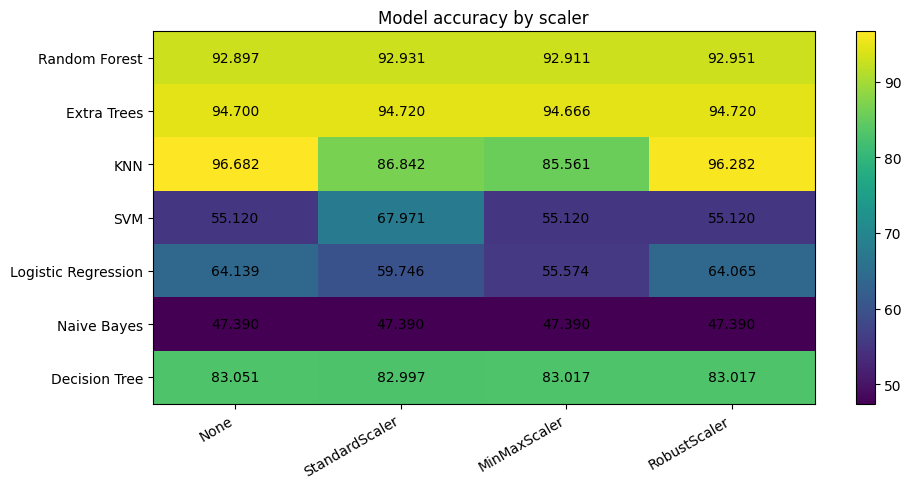

In [52]:
def run_classifiers_matrix(X=None, y=None, scalers_dict=None, cv=None, sampler=None):
    algorithms = {
        "Random Forest": run_random_forest_classifier,
        "Extra Trees": run_extra_trees_classifier,
        "KNN": run_knn_classifier,
        "SVM": run_svm_classifier,
        "Logistic Regression": run_logistic_regression_classifier,
        "Naive Bayes": run_naive_bayes_classifier,
        "Decision Tree": run_decision_tree_classifier,
    }

    matrix = pd.DataFrame(index=algorithms.keys(), columns=scalers_dict.keys(), dtype=float)

    for algo_name, algo_fn in algorithms.items():
        for scaler_name, preprocessors in scalers_dict.items():
            acc = algo_fn(X=X, y=y, preprocessors=preprocessors, sampler=sampler, cv=cv) * 100
            matrix.loc[algo_name, scaler_name] = acc

    return matrix

def plot_matrix_heatmap(df, title="Accuracy matrix"):
    data = df.values.astype(float)

    fig, ax = plt.subplots(figsize=(10, 5))
    im = ax.imshow(data, aspect="auto") 

    ax.set_title(title)
    ax.set_xticks(np.arange(df.shape[1]))
    ax.set_yticks(np.arange(df.shape[0]))
    ax.set_xticklabels(df.columns, rotation=30, ha="right")
    ax.set_yticklabels(df.index)

    for i in range(df.shape[0]):
        for j in range(df.shape[1]):
            val = data[i, j]
            txt = "NA" if np.isnan(val) else f"{val:.3f}"
            ax.text(j, i, txt, ha="center", va="center")

    fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()
    
scalers = {
    "None": [],
    "StandardScaler": [StandardScaler()],
    "MinMaxScaler": [MinMaxScaler()],   
    "RobustScaler": [RobustScaler()],
}

acc_matrix_baseline = run_classifiers_matrix(
    X=X, y=y,  
    scalers_dict=scalers,
    cv=5    
)
plot_matrix_heatmap(acc_matrix_baseline, title="Model accuracy by scaler")


Zaključci:
KNN bez standardizacije daje najbolje rezultate.
Nakon njega je Extra Trees koji najbolje rezultate daje sa MinMax skalarom.

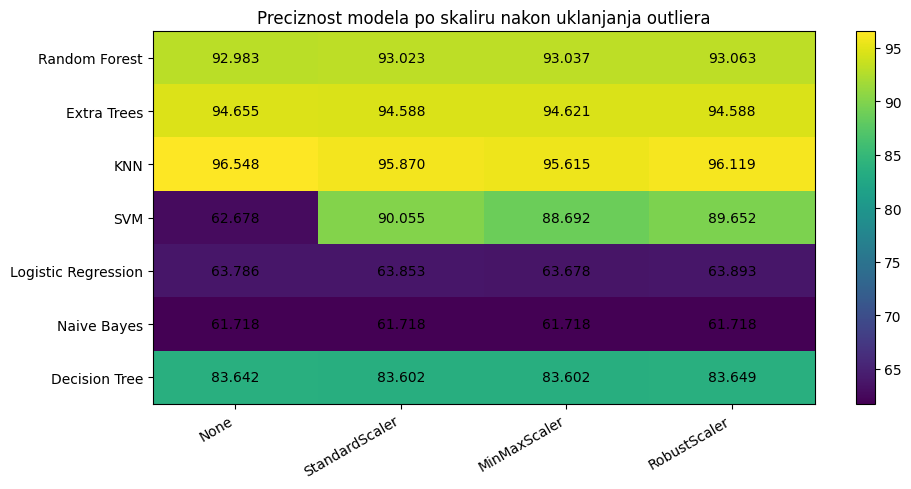

In [53]:
df_no_outliers = df[~zscore_mask]

y_no_outliers = df_no_outliers['eyeDetection']

X_no_outliers = df_no_outliers.drop(
    ['eyeDetection'],
    axis=1
)

scalers = {
    "None": [],
    "StandardScaler": [StandardScaler()],
    "MinMaxScaler": [MinMaxScaler()],
    "RobustScaler": [RobustScaler()],
}

acc_matrix_no_outliers = run_classifiers_matrix(X=X_no_outliers, y=y_no_outliers, scalers_dict=scalers, cv=5)
plot_matrix_heatmap(acc_matrix_no_outliers, title="Preciznost modela po skaliru nakon uklanjanja outliera")

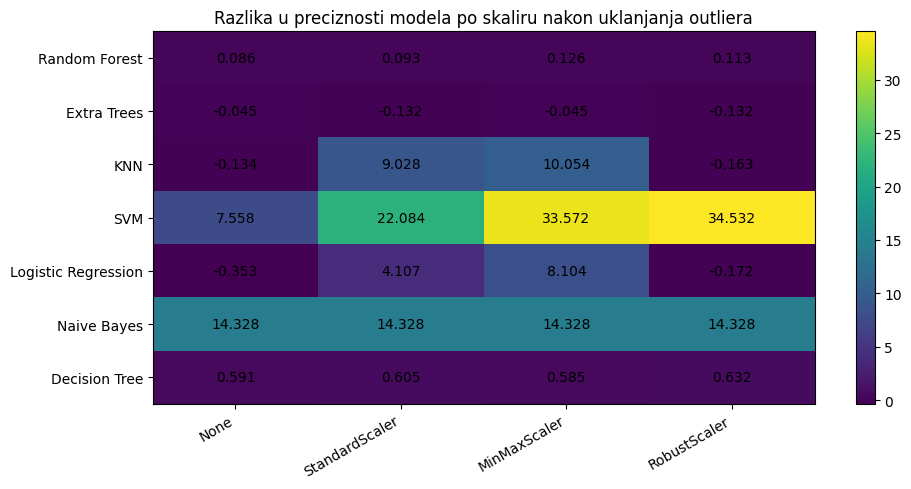

In [54]:
plot_matrix_heatmap(acc_matrix_no_outliers - acc_matrix_baseline, title="Razlika u preciznosti modela po skaliru nakon uklanjanja outliera")

Uklanjanje outlier-a nije dovelo do poboljšanja preciznosti najboljih modela. KNN sa outlier-ima daje najbolje rezultate, kao i Extra Trees sa MinMax Skalarom.

Iz matrice se može videti da je uglavnom došlo do poboljšanja preciznosti većine modela. Preciznost kod Decision Tree i KNN je opala.

### Balansiranje

S obzirom da uklanjanje outlier-a nije dovelo do poboljšanja preciznosti, zadržaćemo dataset sa outlier-ima. Ovo može da ima smisla jer fičeri predstavljaju signale.

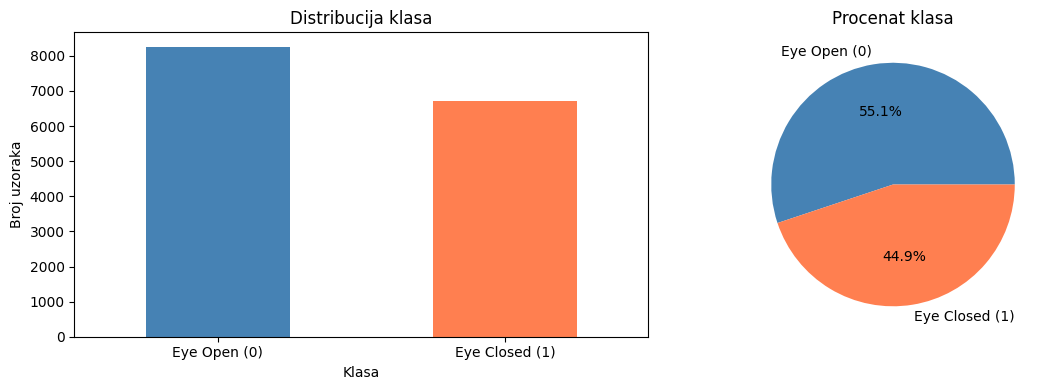

Imbalance ratio: 1.23:1


In [55]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

y.value_counts().plot(kind='bar', ax=ax[0], color=['steelblue', 'coral'])
ax[0].set_title('Distribucija klasa')
ax[0].set_xlabel('Klasa')
ax[0].set_ylabel('Broj uzoraka')
ax[0].set_xticklabels(['Eye Open (0)', 'Eye Closed (1)'], rotation=0)

y.value_counts().plot(kind='pie', ax=ax[1], autopct='%1.1f%%', 
                                         labels=['Eye Open (0)', 'Eye Closed (1)'],
                                         colors=['steelblue', 'coral'])
ax[1].set_title('Procenat klasa')
ax[1].set_ylabel('')

plt.tight_layout()
plt.show()

imbalance_ratio = y.value_counts().max() / y.value_counts().min()
print(f"Imbalance ratio: {imbalance_ratio:.2f}:1")

#### Metode balansiranja

Isprobane su sledeće metode balansiranja:

1. **Random Oversampling** - duplikacija manjinske klase
2. **Random Undersampling** - smanjenje većinske klase
3. **SMOTE** - generisanje sintetičkih uzoraka manjinske klase
4. **ADASYN** - adaptivno generisanje sintetičkih uzoraka
5. **SMOTETomek** - kombinacija SMOTE i Tomek links
6. **SMOTEENN** - kombinacija SMOTE i Edited Nearest Neighbours

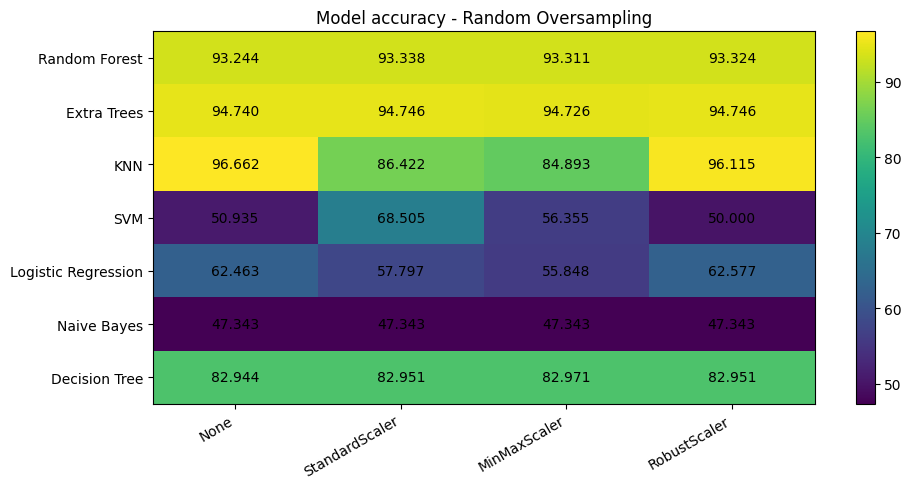

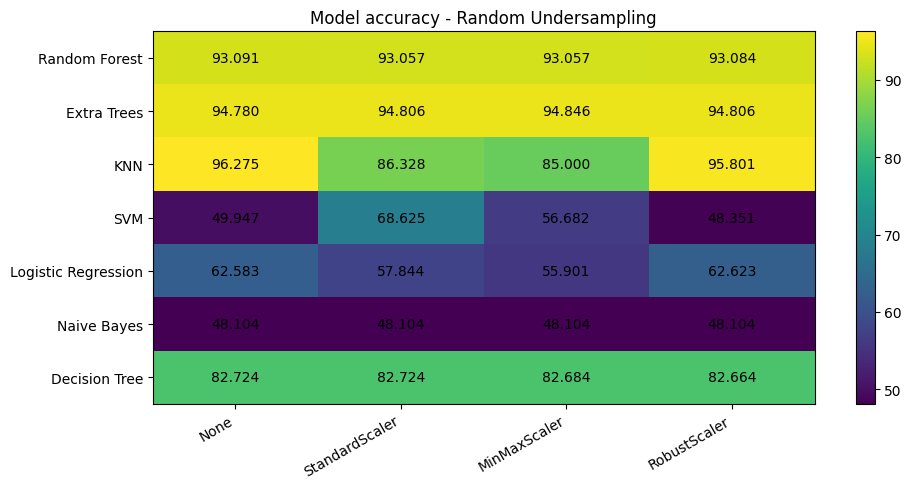

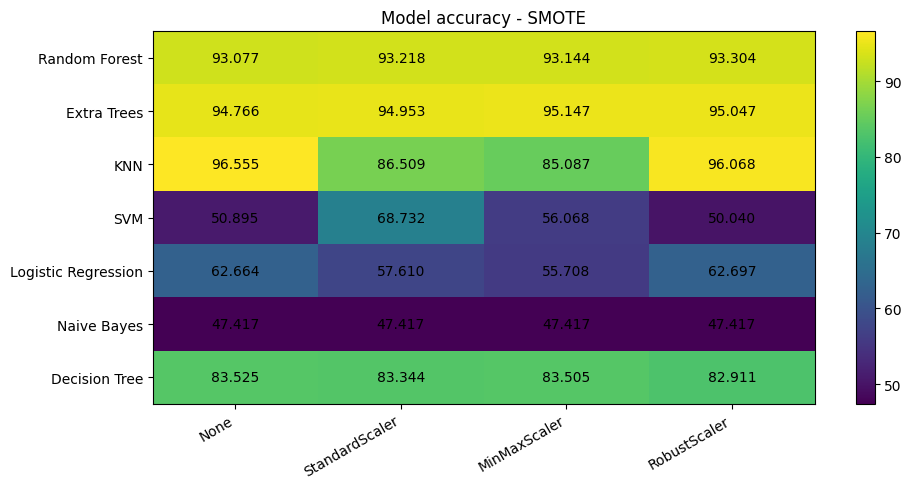

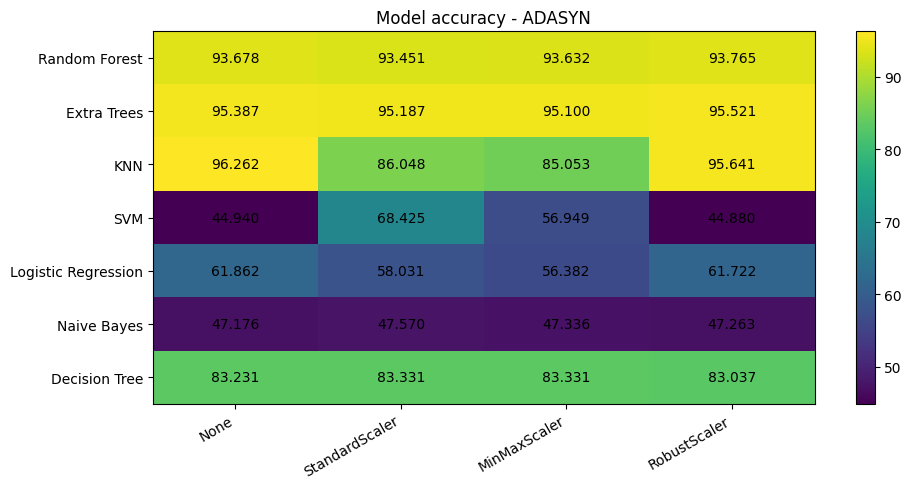

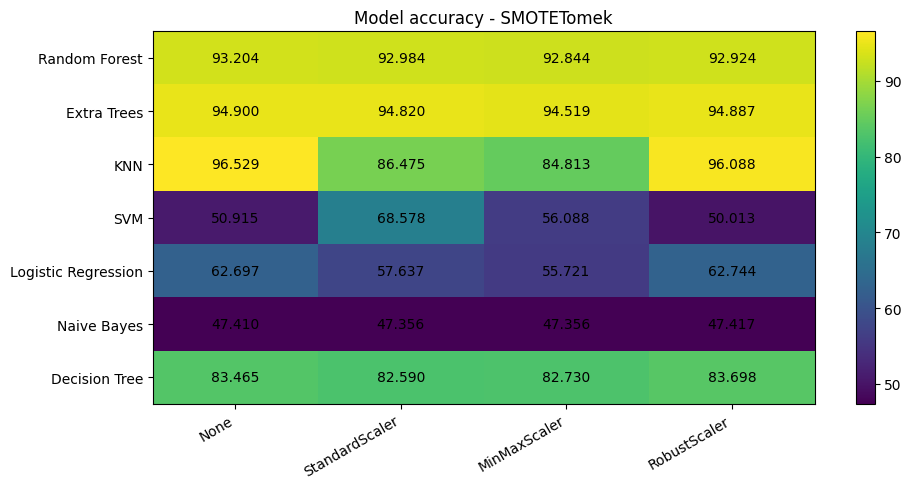

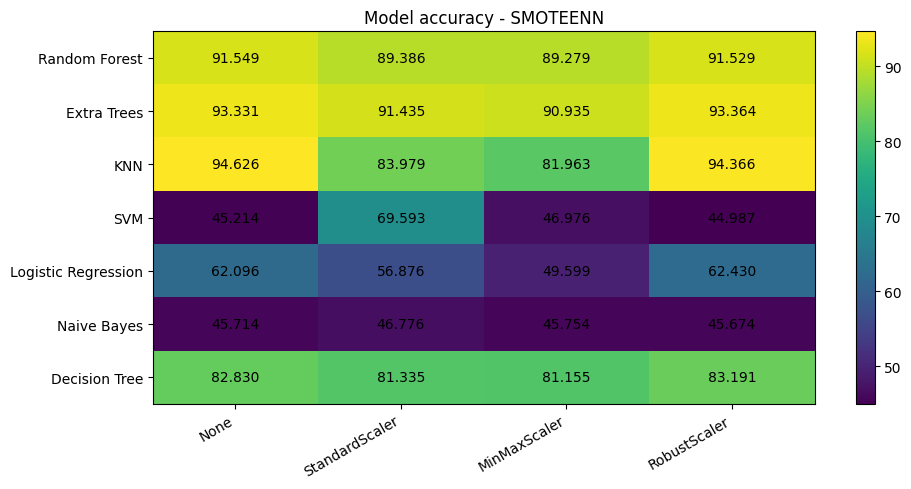

In [57]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek, SMOTEENN

def evaluate_balancing_methods(X=None, y=None, cv=None):
    balancing_methods = {
        "Random Oversampling": RandomOverSampler(random_state=42),
        "Random Undersampling": RandomUnderSampler(random_state=42),
        "SMOTE": SMOTE(random_state=42),
        "ADASYN": ADASYN(random_state=42),
        "SMOTETomek": SMOTETomek(random_state=42),
        "SMOTEENN": SMOTEENN(random_state=42)
    }
    
    results = []
    balanced_datasets = {}
    
    for method_name, sampler in balancing_methods.items():
        balanced_datasets[method_name] = (X, y)
            
        res = run_classifiers_matrix(
                X=X,
                y=y,
                scalers_dict=scalers,
                sampler=sampler,
                cv=cv
        )
            
        plot_matrix_heatmap(res, title="Model accuracy - " + method_name)
        results.append({
            "Balancing Method": method_name,
            "Accuracy Matrix": res
        })
    
    return pd.DataFrame(results), balanced_datasets

balancing_results, balanced_datasets = evaluate_balancing_methods(
    X=X,
    y=y,
    cv=5
)

# bilo je pre bez outliera


Možemo uočiti da ni jedan metod ne poboljšava preciznost i KNN i Extra Trees klasifikatora, pa nećemo primeniti balansiranje.

### Uklanjanje visoko korelisanih feature-a

Na osnovu ranije analize korelacije, uklanjamo redundantne feature-e koji imaju korelaciju > 0.95.

In [58]:
def run_extra_trees(X, y, cv):
    return run_extra_trees_classifier([MinMaxScaler()], X, y, cv) * 100

def run_knn(X, y, cv):
    return run_knn_classifier([], X, y, cv) * 100

In [59]:
import itertools
import numpy as np
import pandas as pd

def get_high_corr_pairs(df: pd.DataFrame, threshold: float = 0.9):
    corr = df.corr().abs()
    cols = list(corr.columns)

    pairs = []
    for i in range(len(cols)):
        for j in range(i + 1, len(cols)):
            v = corr.iloc[i, j]
            if v > threshold:
                pairs.append((cols[i], cols[j], float(v)))
    return pairs

def evaluate_hight_corr_drops2(X, y, pairs, max_drop=5, cv=5):
    all_corr_cols = set()
    for col_a, col_b, _ in pairs:
        all_corr_cols.add(col_a)
        all_corr_cols.add(col_b)
    
    all_corr_cols = list(all_corr_cols)
    
    knn_results = []
    xtra_trees_results = []
    
    for num_to_drop in range(1, min(max_drop + 1, len(all_corr_cols) + 1)):
        combinations = itertools.combinations(all_corr_cols, num_to_drop)
        
        for drop_set in combinations:
            drop_set = list(drop_set)
            X_reduced = X.drop(columns=drop_set)

            knn_result = run_knn(X_reduced, y, cv)
            knn_results.append({
                "Dropped Columns": drop_set,
                "Num Dropped": len(drop_set),
                "Accuracy (%)": knn_result,
                "Remaining Features": X_reduced.shape[1],
            })

            xtra_trees_result = run_extra_trees(X_reduced, y, cv)
            xtra_trees_results.append({
                "Dropped Columns": drop_set,
                "Num Dropped": len(drop_set),
                "Accuracy (%)": xtra_trees_result,
                "Remaining Features": X_reduced.shape[1],
            })
    
    knn_results_df = pd.DataFrame(knn_results)
    knn_results_df = knn_results_df.sort_values(by="Accuracy (%)", ascending=False)
    
    xtra_trees_results_df = pd.DataFrame(xtra_trees_results)
    xtra_trees_results_df = xtra_trees_results_df.sort_values(by="Accuracy (%)", ascending=False)

    print("KNN")
    print(f"\nUkupno varijanti: {len(knn_results_df)}")
    print("\nTop 10 najboljih kombinacija:")
    print(knn_results_df.head(10).to_string(index=False))

    print("Extra Trees")
    print(f"\nUkupno varijanti: {len(xtra_trees_results_df)}")
    print("\nTop 10 najboljih kombinacija:")
    print(xtra_trees_results_df.head(10).to_string(index=False))

pairs = get_high_corr_pairs(X, threshold=0.95)
evaluate_hight_corr_drops2(X, y, pairs, 5)

KNN

Ukupno varijanti: 119

Top 10 najboljih kombinacija:
Dropped Columns  Num Dropped  Accuracy (%)  Remaining Features
           [P8]            1     96.755674                  13
      [AF4, P8]            2     96.428571                  12
      [FC5, P8]            2     96.368491                  12
          [AF4]            1     96.234980                  13
      [AF3, P8]            2     96.221629                  12
          [FC5]            1     96.148198                  13
       [P8, P7]            2     96.081442                  12
           [P7]            1     96.068091                  13
       [F8, P8]            2     96.028037                  12
          [AF3]            1     95.974633                  13
Extra Trees

Ukupno varijanti: 119

Top 10 najboljih kombinacija:
Dropped Columns  Num Dropped  Accuracy (%)  Remaining Features
           [P8]            1     94.893191                  13
       [P8, P7]            2     94.519359               

Može se primetiti da bi izbacivanje kolone P8 poboljšalo rezultate i KNN i Xtra Trees algoritma, pa ćemo tu kolonu izbaciti jer je visoko korelisana sa AF3 i F8.

In [60]:
X_no_P8 = X.drop(columns=['P8'])

### Redukcija dimenzionalnosti (PCA)

Primenjujemo PCA (Principal Component Analysis) za redukciju dimenzionalnosti sa zadržavanjem 95% varijanse.

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.p

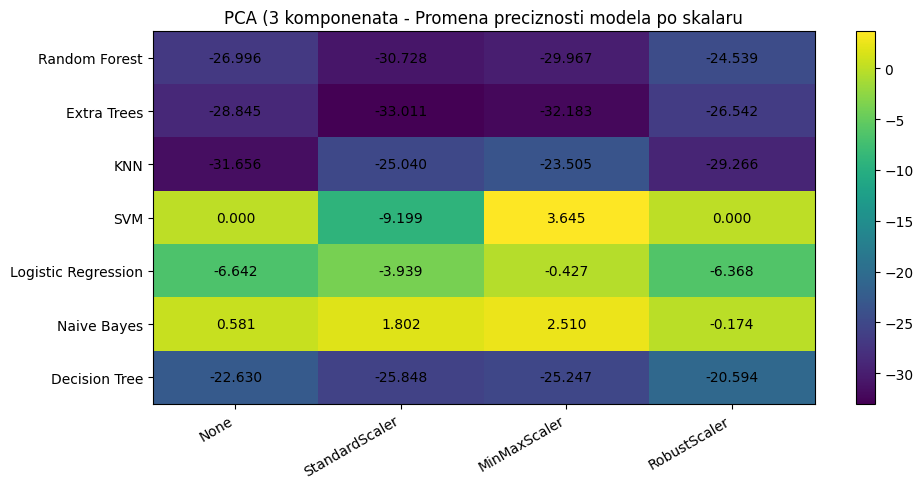

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.p

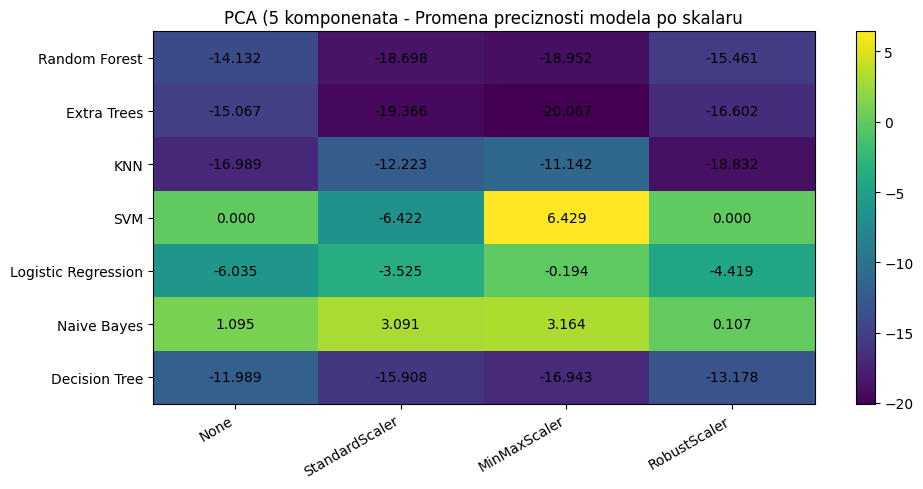

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.p

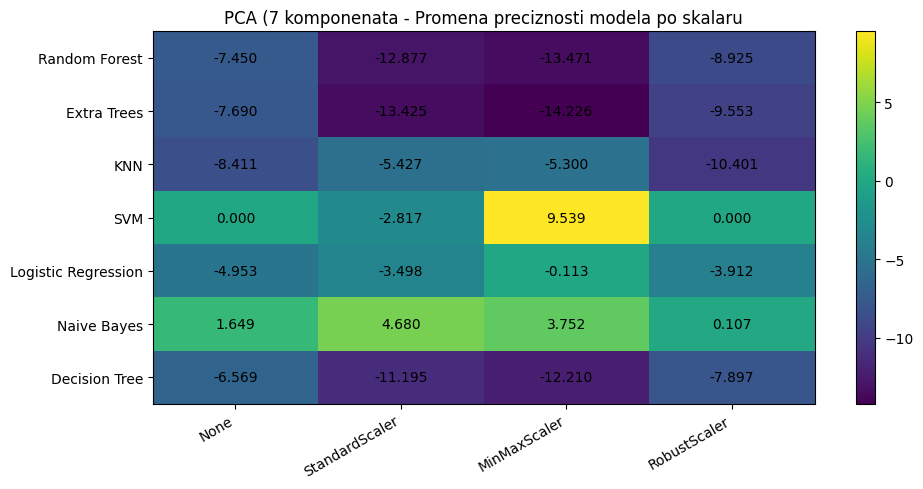

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.p

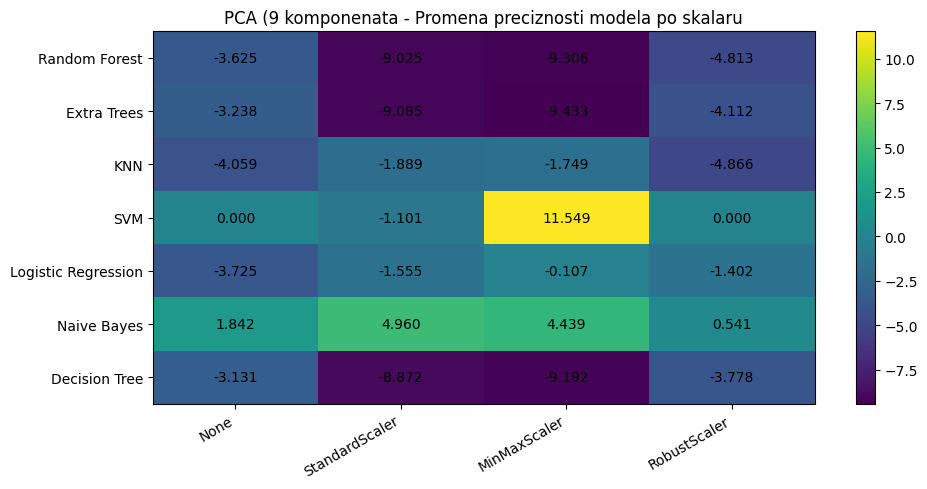

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.p

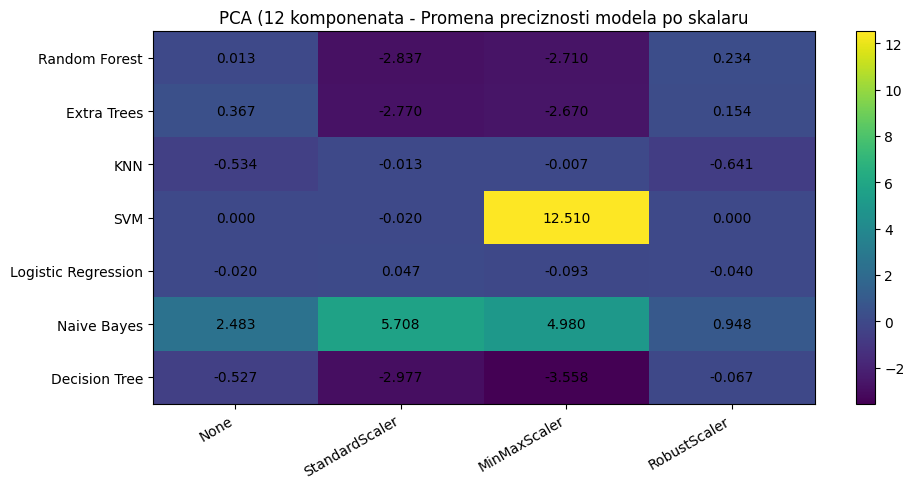

In [61]:
pca_results = []

for n_components in [3, 5, 7, 9, 12]:
    pca = PCA(n_components=n_components)

    scalers_with_pca = {
        scaler_name: (preprocessors + [PCA(n_components=n_components, random_state=42)])
        for scaler_name, preprocessors in scalers.items()
    }

    res = run_classifiers_matrix(X=X_no_P8, y=y, scalers_dict=scalers_with_pca, cv=5)
    plot_matrix_heatmap(res - run_classifiers_matrix(X=X_no_P8, y=y, scalers_dict=scalers, cv=5), title=f"PCA ({n_components} komponenata - Promena preciznosti modela po skalaru")

    pca_results.append({
        "n_components": n_components,
        "accuracy": res
    })

Iz prilozenog mozemo videti da preciznost znatno opada za KNN i ExtraTrees koji su nam do sada pokazali najbolje rezultate kao i za vecinu ostalih. Znatno poboljsanje vidmo za SVM algoritam kada se koristi i MinMaxScaler

### Optimizacija hiperparametara

In [58]:
X_train_no_P8, X_test_no_P8, y_train_no_P8, y_test_no_P8 = train_test_split(
    X_no_P8, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [ ]:
print("\n--- Extra Trees optimizacija ---")

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipe = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", ExtraTreesClassifier(
        random_state=42,
        class_weight="balanced",
        n_jobs=-1
    ))
])

param_dist = {
    "model__n_estimators": [100, 200, 300, 500, 800],
    "model__max_depth": [None, 10, 20, 30],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["sqrt", "log2", None], 
    "model__criterion": ["gini", "entropy"],
    "model__bootstrap": [False, True],               
}

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=50,                       
    scoring="accuracy",      
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

search.fit(X_no_P8, y)

print("Najbolji parametri:", search.best_params_)
print(f"Najbolja CV accuracy: {search.best_score_ * 100:.2f}%")

extra_trees_best = search.best_estimator_

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

# Baseline (pre optimizacije)
baseline_pipe = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", ExtraTreesClassifier(
        random_state=42,
        class_weight="balanced",
        n_jobs=-1
    ))
])

base = report("baseline", baseline_pipe, X_no_P8, y, cv=5)["accuracy"] * 100
tuned = report("tuned", extra_trees_best, X_no_P8, y, cv=5)["accuracy"] * 100

print(f"baseline: {base:.3f}%")
print(f"tuned:    {tuned:.3f}%")
print(f"delta:    {tuned - base:+.3f} pp")



--- Extra Trees optimizacija ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Najbolji parametri: {'model__n_estimators': 100, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_features': None, 'model__max_depth': None, 'model__criterion': 'entropy', 'model__bootstrap': False}
Najbolja CV balanced accuracy: 94.93%
baseline: 94.887%
tuned:    94.933%
delta:    +0.047 pp


In [78]:
# KNN optimizacija

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline

print("\n--- KNN optimizacija ---")


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipe_knn = Pipeline([
    ("model", KNeighborsClassifier())
])

param_dist_knn = {
    "model__n_neighbors": list(range(3, 51, 2)),  
    "model__weights": ["uniform", "distance"],
    "model__p": [1, 2],  # 1=Manhattan, 2=Euclidean
}

# RandomizedSearchCV
search_knn = RandomizedSearchCV(
    estimator=pipe_knn,
    param_distributions=param_dist_knn,
    n_iter=30,
    scoring="accuracy",     
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# CV je UNUTRA
search_knn.fit(X_no_P8, y)

print("Najbolji KNN parametri:", search_knn.best_params_)
print(f"Najbolja CV accuracy: {search_knn.best_score_ * 100:.2f}%")

# Najbolji KNN model
knn_best_no_sc = search_knn.best_estimator_

from sklearn.pipeline import Pipeline

# Baseline KNN
baseline_knn_no_sc = Pipeline([
    ("model", KNeighborsClassifier())
])

base_knn_no_sc = report("baseline_knn", baseline_knn_no_sc, X_no_P8, y, cv=5)["accuracy"] * 100
tuned_knn_no_sc = report("tuned_knn", knn_best_no_sc, X_no_P8, y, cv=5)["accuracy"] * 100

print(f"KNN baseline: {base_knn_no_sc:.3f}%")
print(f"KNN tuned:    {tuned_knn_no_sc:.3f}%")
print(f"KNN delta:    {tuned_knn_no_sc - base_knn_no_sc:+.3f} pp")


# \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\




# # KNN optimizacija SA ROUBUST SCALEROM, jer se uz knn uvek preporucuje skaliranje


print("\n--- KNN optimizacija SA ROUBUST SCALEROM ---")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipe_knn = Pipeline([
    ("scaler", RobustScaler()),
    ("model", KNeighborsClassifier())
])

param_dist_knn = {
    "model__n_neighbors": list(range(3, 51, 2)),  
    "model__weights": ["uniform", "distance"],
    "model__p": [1, 2],  
}

search_knn = RandomizedSearchCV(
    estimator=pipe_knn,
    param_distributions=param_dist_knn,
    n_iter=30,
    scoring="accuracy",     
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

search_knn.fit(X_no_P8, y)

print("Najbolji KNN parametri:", search_knn.best_params_)
print(f"Najbolja CV accuracy: {search_knn.best_score_ * 100:.2f}%")

knn_best = search_knn.best_estimator_

from sklearn.pipeline import Pipeline

baseline_knn = Pipeline([
    ("scaler", RobustScaler()),
    ("model", KNeighborsClassifier())
])

base_knn = report("baseline_knn", baseline_knn, X_no_P8, y, cv=5)["accuracy"] * 100
tuned_knn = report("tuned_knn", knn_best, X_no_P8, y, cv=5)["accuracy"] * 100

print(f"KNN baseline sa scalerom: {base_knn:.3f}%")
print(f"KNN tuned sa scalerom:    {tuned_knn:.3f}%")
print(f"KNN delta:    {tuned_knn - base_knn:+.3f} pp")


--- KNN optimizacija ---
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Najbolji KNN parametri: {'model__weights': 'uniform', 'model__p': 1, 'model__n_neighbors': 3}
Najbolja CV accuracy: 97.03%
KNN baseline: 96.756%
KNN tuned:    97.029%
KNN delta:    +0.274 pp

--- KNN optimizacija SA ROUBUST SCALEROM ---
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Najbolji KNN parametri: {'model__weights': 'uniform', 'model__p': 1, 'model__n_neighbors': 3}
Najbolja CV accuracy: 96.87%
KNN baseline sa scalerom: 96.602%
KNN tuned sa scalerom:    96.869%
KNN delta:    +0.267 pp



--- Promena u odnosu na baseline (pp) ---
      Model  Promena (pp)
Extra Trees         0.047
        KNN         0.274


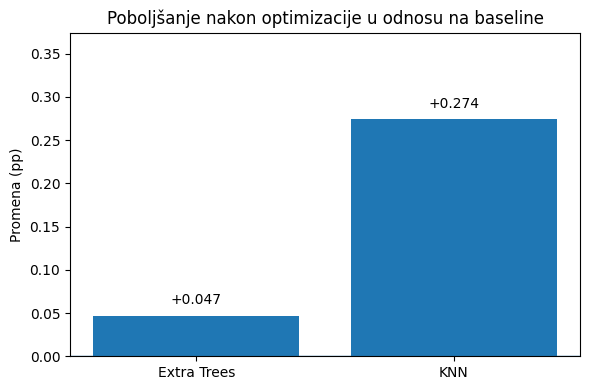

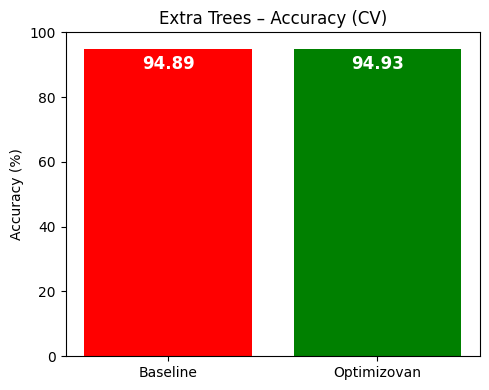

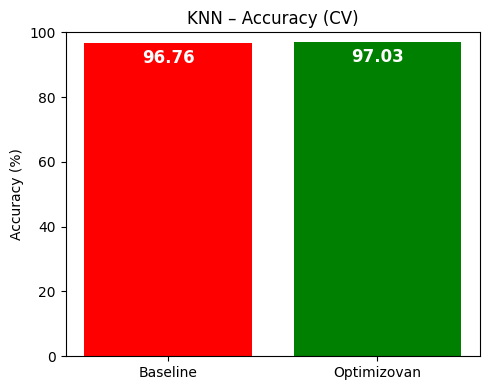

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

delta_et = tuned - base
delta_knn = tuned_knn_no_sc - base_knn_no_sc

delta_df = pd.DataFrame([
    {"Model": "Extra Trees", "Promena (pp)": round(delta_et, 3)},
    {"Model": "KNN",         "Promena (pp)": round(delta_knn, 3)}
])

print("\n--- Promena u odnosu na baseline (pp) ---")
print(delta_df.to_string(index=False))

# Plot promena
plt.figure(figsize=(6, 4))
x = np.arange(len(delta_df))
bars = plt.bar(x, delta_df["Promena (pp)"])

plt.axhline(0, linewidth=1)
plt.ylabel("Promena (pp)")
plt.title("Poboljšanje nakon optimizacije u odnosu na baseline")
plt.xticks(x, delta_df["Model"])

plt.ylim(0, delta_df["Promena (pp)"].max() + 0.1)

for bar in bars:
    h = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        h + 0.01,          
        f"{h:+.3f}",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.tight_layout()
plt.show()

# Extra Trees plot
import matplotlib.pyplot as plt

et_values = {
    "Baseline": base,
    "Optimizovan": tuned
}

labels = list(et_values.keys())
values = list(et_values.values())

max_val = max(values)
colors = ["green" if v == max_val else "red" for v in values]

plt.figure(figsize=(5, 4))
bars = plt.bar(labels, values, color=colors)

plt.title("Extra Trees – Accuracy (CV)")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)

for bar in bars:
    h = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        h - 2,                 
        f"{h:.2f}",
        ha="center",
        va="top",
        fontsize=12,
        color="white",        
        fontweight="bold"
    )

plt.tight_layout()
plt.show()



# KNN plot
knn_values = {
    "Baseline": base_knn_no_sc,
    "Optimizovan": tuned_knn_no_sc
}

labels = list(knn_values.keys())
values = list(knn_values.values())

max_val = max(values)
colors = ["green" if v == max_val else "red" for v in values]

plt.figure(figsize=(5, 4))
bars = plt.bar(labels, values, color=colors)

plt.title("KNN – Accuracy (CV)")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)

for bar in bars:
    h = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        h - 2,
        f"{h:.2f}",
        ha="center",
        va="top",
        fontsize=12,
        color="white",
        fontweight="bold"
    )

plt.tight_layout()
plt.show()




## 6. Analiza interpretabilnosti modela

U ovom delu analiziramo interpretabilnost modela koristeći:
- **Feature Importance** - značaj feature-a u tree-based modelima
- **SHAP vrednosti** - SHapley Additive exPlanations
- **LIME** - Local Interpretable Model-agnostic Explanations

### 6.1 Feature Importance (Knn & Extra Trees)

In [91]:
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt

feature_names = X.columns.tolist()

# Extra Trees importance
et_importance = pd.DataFrame({
    "Feature": feature_names,
    "Importance": extra_trees_best.named_steps["model"].feature_importances_
}).sort_values("Importance", ascending=False)

# KNN permutation importance
perm = permutation_importance(
    knn_best_no_sc,   
    X,
    y,
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
    scoring="accuracy"
)

knn_importance = pd.DataFrame({
    "Feature": feature_names,
    "Importance": perm.importances_mean
}).sort_values("Importance", ascending=False)


# plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Extra Trees
axes[0].barh(
    et_importance["Feature"],
    et_importance["Importance"],
    color="coral"
)
axes[0].set_xlabel("Importance")
axes[0].set_title("Extra Trees - Feature Importance")
axes[0].invert_yaxis()

# KNN
axes[1].barh(
    knn_importance["Feature"],
    knn_importance["Importance"],
    color="steelblue"
)
axes[1].set_xlabel("Importance")
axes[1].set_title("KNN - Permutation Importance")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()



ValueError: All arrays must be of the same length

### SHAP Analiza (SHapley Additive exPlanations)

SHAP vrednosti pokazuju doprinos svakog feature-a predikciji modela.

### LIME Analiza (Local Interpretable Model-agnostic Explanations)

LIME objašnjava pojedinačne predikcije kreirajući lokalni interpretabilan model.